In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import socket
import sys
import os
home = os.path.expanduser("~")
from glob import glob as gg
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import xarray as xr
import time
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import seaborn as sns

Autosaving every 5 seconds


In [2]:
##############################################

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=2)
plt.rc('axes', grid=False)
plt.rc('axes', edgecolor='black')

plt.rc('ytick.major', size = 2)
plt.rc('ytick.major', width = 2)
plt.rc('xtick.minor', visible = True)
plt.rc('xtick.major', size = 2)
plt.rc('xtick.minor', size = 1)
plt.rc('xtick.major', width = 2)
plt.rc('xtick.minor', width = 1)

plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('pdf', fonttype = 42)

palette = sns.color_palette("Spectral", n_colors = 6)

#################################################

In [3]:
# load model data
data_path = home+'/nuarctic_temp/nuarctic/REcoM1D/results/'
output_file = 'REcoM1d_outputs.nc'
diag_file = 'REcoM1d_diagnostics.nc'
outputs = xr.open_dataset(data_path+output_file)
diags = xr.open_dataset(data_path+diag_file)
dates = pd.to_datetime(outputs['year'].data * 1000 + outputs['day'].data, format='%Y%j')

In [4]:
# load Chl-a in situ data
obs_path = '/home/ollie/loziel/nuarctic_temp/nuarctic/data/'
df_chla = pd.read_excel(obs_path+'CHLA/MOSAiC_Chla_forLaurent_20220905.xlsx')

In [5]:
# load Nutrients in situ data
df_nut = pd.read_csv(obs_path+'NUTRIENTS/06AQ20190920.csv', header = 14, na_values=-999)
df_nut['time'] = pd.to_datetime((df_nut['DATE']), format='%Y%m%d')

In [6]:
# load CTD Polarstern
filename_CTD_data = obs_path+'CTD_Rosette/Polarstern/PS122_*_Polarstern.txt'

files = gg(filename_CTD_data, recursive = True)
files = np.sort(files)

for i in np.arange(0,len(files)):
    print(files[i])
    df_temp = pd.read_csv(files[i], index_col = 'Date/Time', sep="\t", parse_dates=['Date/Time'])
    
    if i==0:
        df = df_temp
    else:
        df = pd.concat([df, df_temp])

/home/ollie/loziel/nuarctic_temp/nuarctic/data/CTD_Rosette/Polarstern/PS122_1_Polarstern.txt
/home/ollie/loziel/nuarctic_temp/nuarctic/data/CTD_Rosette/Polarstern/PS122_2_Polarstern.txt
/home/ollie/loziel/nuarctic_temp/nuarctic/data/CTD_Rosette/Polarstern/PS122_3_Polarstern.txt
/home/ollie/loziel/nuarctic_temp/nuarctic/data/CTD_Rosette/Polarstern/PS122_4_Polarstern.txt
/home/ollie/loziel/nuarctic_temp/nuarctic/data/CTD_Rosette/Polarstern/PS122_5_Polarstern.txt


In [7]:
# load UVP-POC in situ data
df_uvp = pd.read_csv(obs_path+'UVP/MOSAIC_C_pred_consolidated.csv')
df_uvp['Date'] = pd.to_datetime(df_uvp['Date'], format = '%Y-%m-%d')

# df_uvp['C_>100_µm_predicted_[µg_L-1]'][df_uvp['C_>100_µm_predicted_[µg_L-1]']<= 10] = np.nan
# df_uvp_notnan = df_uvp[df_uvp['C_>100_µm_predicted_[µg_L-1]'].notna()]
# df_uvp_notnan['Date'] = pd.to_datetime(df_uvp_notnan['Date'], format = '%Y-%m-%d')

In [8]:
# re-constitute datetime index from Andreas Rogge file

# datetime_list = []

# for index, row in df_uvp.iterrows():
#     tmp = row['ctd_station']
#     tmp_1 = tmp[2:5]
#     tmp_2 = tmp[6:9]
#     tmp_3 = tmp[10:]

#     tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#     idx = df.index[df['Event Label'] == tag].to_list()
    
#     if np.any(idx):
#         datetime_list.append(pd.to_datetime(idx[0]))
#     else:
#         tmp_1 = tmp[2:5]
#         tmp_2 = tmp[6:10]
#         tmp_3 = tmp[11:]
#         tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#         idx = df.index[df['Event Label'] == tag].to_list()
        
#         if np.any(idx):
#             datetime_list.append(pd.to_datetime(idx[0]))
#         else:
#             tmp_1 = tmp[2:5]
#             tmp_2 = tmp[6:10]
#             tmp_3 = tmp[11:13]
#             tag = 'PS'+str(tmp_1)+'/'+str(tmp_2)+'-'+str(tmp_3)
#             idx = df.index[df['Event Label'] == tag].to_list()
#             if np.any(idx):
#                 datetime_list.append(pd.to_datetime(idx[0]))
#             else:
#                 print('STILL NO DATE FOUND !!!!!!!')
        
# new_datetime_index = pd.DatetimeIndex(datetime_list)
# df_uvp['Date'] = new_datetime_index
# df_uvp.set_index('Date', inplace=True)
# df_uvp.to_csv(obs_path+'UVP/MOSAIC_C_pred_consolidated.csv')

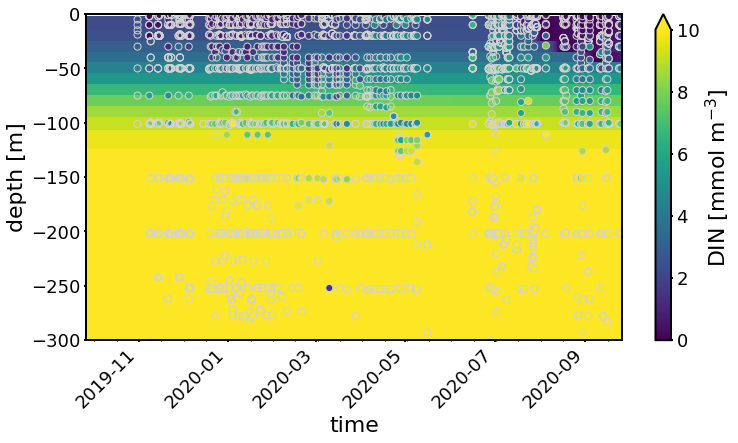

In [144]:
fig, ax = plt.subplots(figsize = (12,6))

pc = ax.pcolor(dates, outputs['z_cell'].data, outputs['DIN'].data, 
               vmin=0, vmax=10)
ax.set_ylim(-300,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_nut['time'], -df_nut['CTDPRS'], 50, df_nut['NITRAT'], edgecolors= 'lightgray',
          vmin=0, vmax=10)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('DIN [mmol m$^{-3}$]')

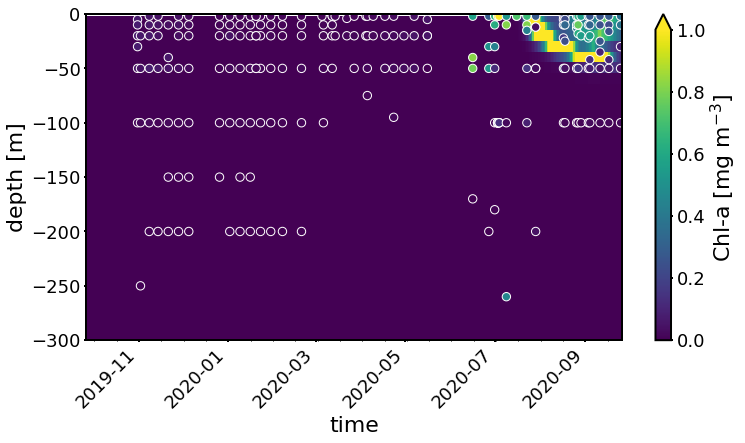

In [143]:
fig, ax = plt.subplots(figsize = (12,6))

pc = ax.pcolor(dates, outputs['z_cell'].data, outputs['DiaChl'].data+outputs['PhyChl'].data, 
               vmin=0, vmax=1)
ax.set_ylim(-300,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_chla['Date'], -df_chla['desired_depth'], 70, df_chla['Chl[µg L-1]'], edgecolors= 'w',
          vmin=0, vmax=1)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('Chl-a [mg m$^{-3}$]')

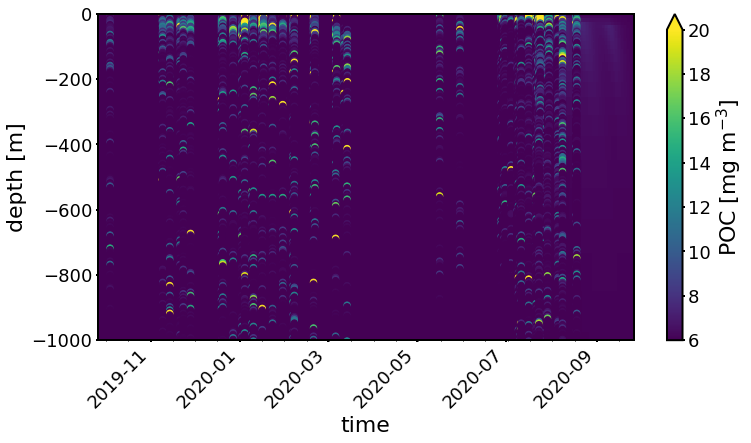

In [20]:
fig, ax = plt.subplots(figsize = (12,6))
vmin = 6
vmax = 20

pc = ax.pcolor(dates, outputs['z_cell'].data, 6+(outputs['DetC'].data+outputs['idetz2c'].data), 
               vmin=vmin, vmax=vmax)
ax.set_ylim(-1000,0)
ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.scatter(df_uvp['Date'], -df_uvp['depth_[m]'], 40, (df_uvp['C_>100_µm_predicted_[µg_L-1]']),
           edgecolors= None,
          vmin=vmin, vmax=vmax)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('POC [mg m$^{-3}$]')

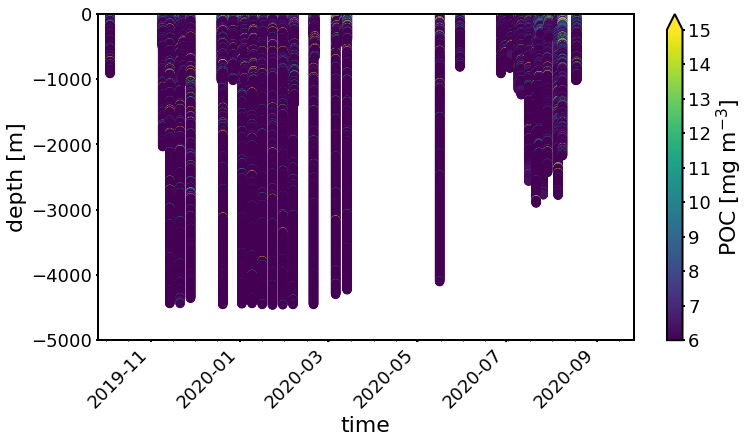

In [23]:
fig, ax = plt.subplots(figsize = (12,6))

pc = ax.scatter(df_uvp['Date'].values, -df_uvp['depth_[m]'], 70, df_uvp['C_>100_µm_predicted_[µg_L-1]'],
          vmin=6, vmax=15)
ax.set_ylim(-5000,0)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_xlim([datetime.date(2019, 9, 26), datetime.date(2020, 9, 26)])

ax.set_xlabel('time')
ax.set_ylabel('depth [m]')

cbar = fig.colorbar(pc, ax = ax, extend='max')
cbar.set_label('POC [mg m$^{-3}$]')

In [24]:
df_uvp

,Date,ctd_station,longitude,latitude,depth_[m],lpm_biovolume_(102-128_µm)_[mm3_l-1],lpm_biovolume_(128-161_µm)_[mm3_l-1],lpm_biovolume_(161-203_µm)_[mm3_l-1],lpm_biovolume_(203-256_µm)_[mm3_l-1],lpm_biovolume_(256-323_µm)_[mm3_l-1],...,lpm_biovolume_(4.1-5.16_mm)_[mm3_l-1],lpm_biovolume_(5.16-6.5_mm)_[mm3_l-1],lpm_biovolume_(6.5-8.19_mm)_[mm3_l-1],lpm_biovolume_(8.19-10.3_mm)_[mm3_l-1],lpm_biovolume_(10.3-13_mm)_[mm3_l-1],lpm_biovolume_(13-16.4_mm)_[mm3_l-1],lpm_biovolume_(16.4-20.6_mm)_[mm3_l-1],lpm_biovolume_(20.6-26_mm)_[mm3_l-1],lpm_biovolume_(>26_mm)_[mm3_l-1],C_>100_µm_predicted_[µg_L-1]
0,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,2.5,0.021406,0.022229,0.049502,0.047119,0.032564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.912068
1,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,7.5,0.008911,0.008390,0.019820,0.020685,0.015772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.500084
2,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,12.5,0.002536,0.002543,0.005917,0.006902,0.005889,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.951609
3,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,17.5,0.001628,0.001577,0.003673,0.006219,0.005039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.149217
4,2019-10-04 08:25:45,ps122_1_2_68,132.55192,85.12810,22.5,0.001529,0.001405,0.004077,0.006558,0.005916,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.111256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25771,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,992.5,0.003547,0.002417,0.003993,0.003026,0.005614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.970171
25772,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,997.5,0.003687,0.002200,0.003870,0.002722,0.004118,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.968294
25773,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,1002.5,0.003519,0.002294,0.003568,0.003100,0.003800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.081711
25774,2020-08-18 06:20:52,ps122_5_59_72,-35.68865,88.93762,1007.5,0.003466,0.002181,0.003441,0.002808,0.003431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.944885


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

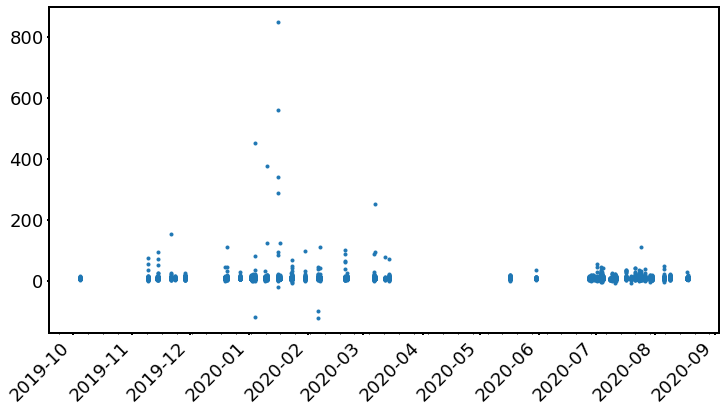

In [33]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(df_uvp['Date'].values, df_uvp['C_>100_µm_predicted_[µg_L-1]'],'.')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

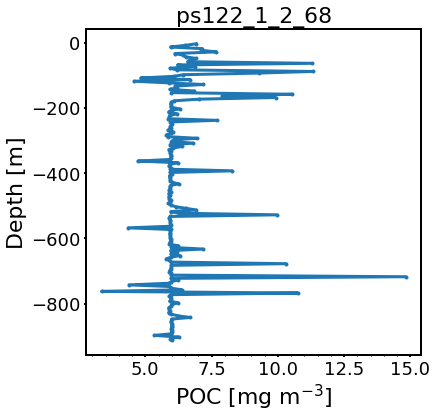

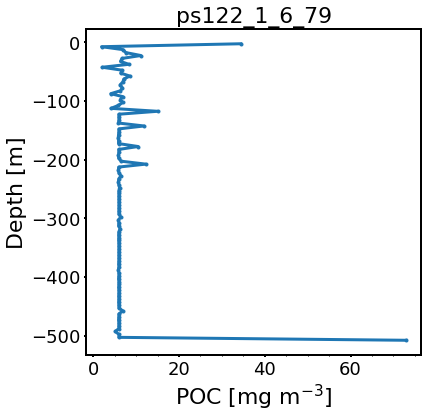

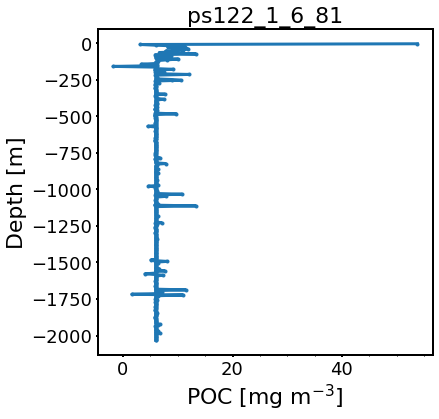

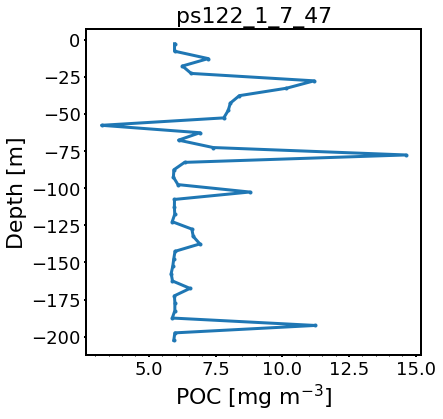

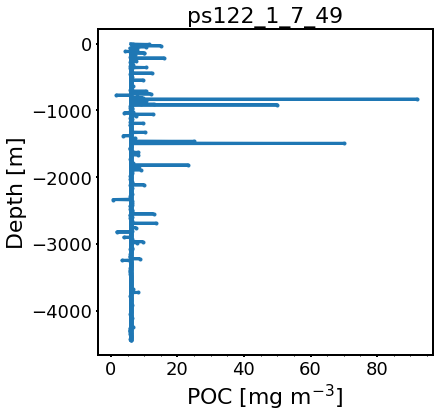

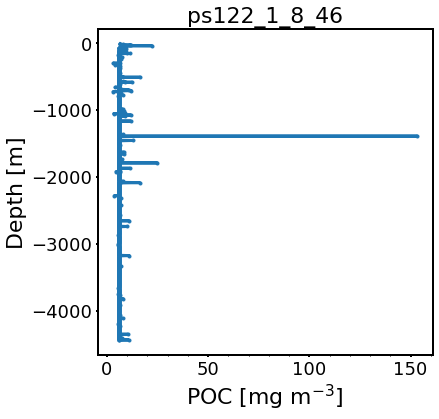

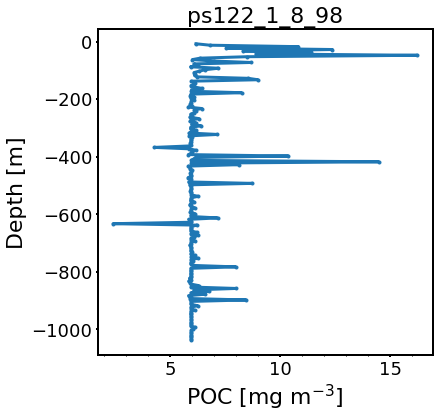

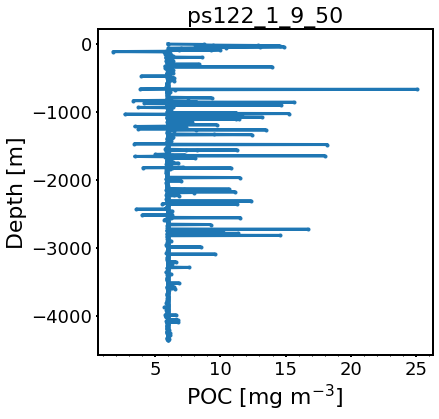

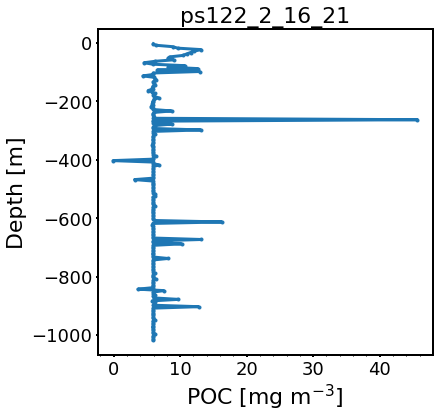

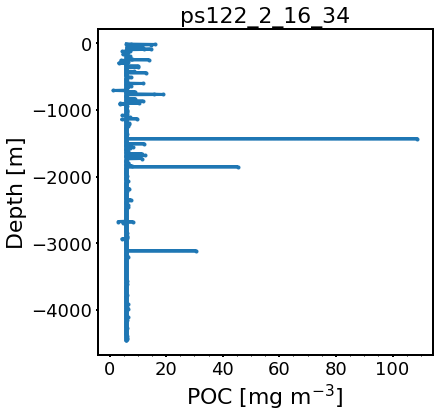

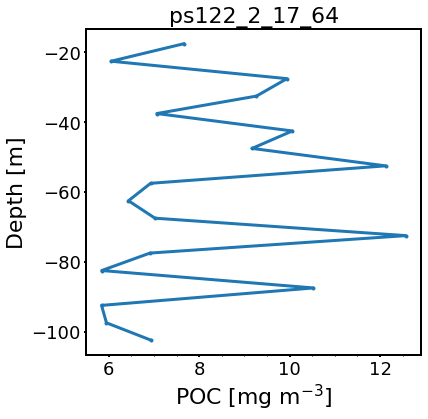

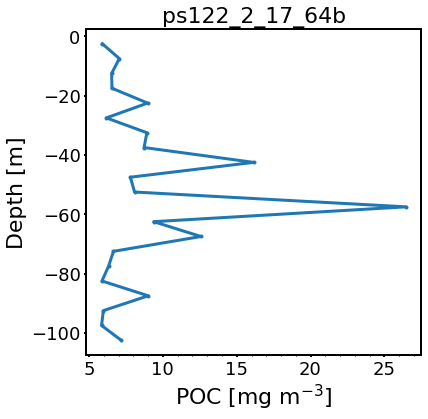

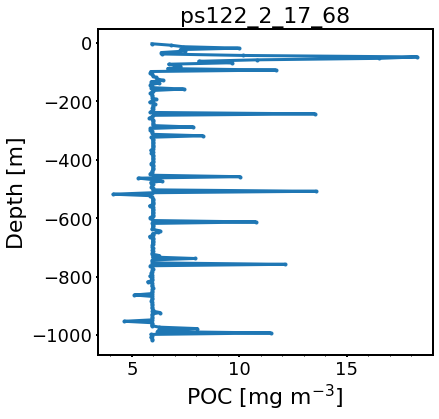

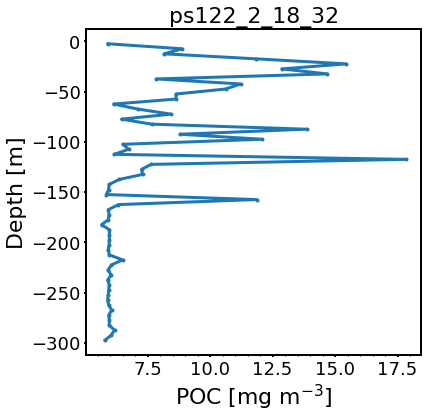

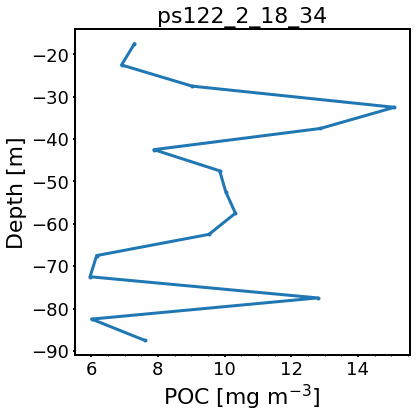

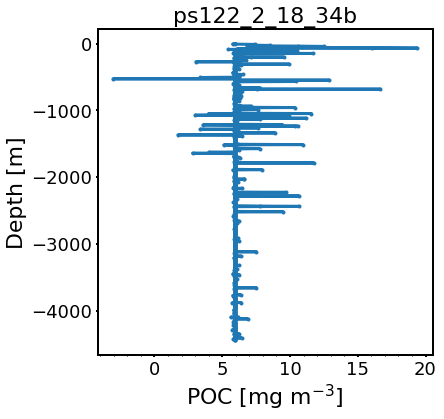

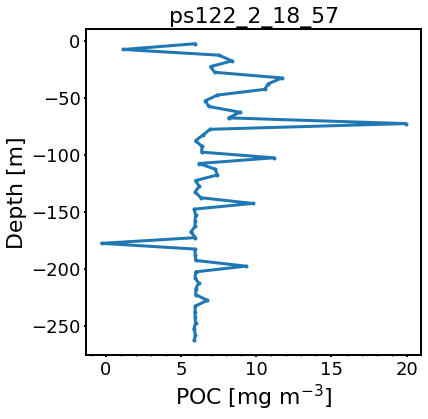

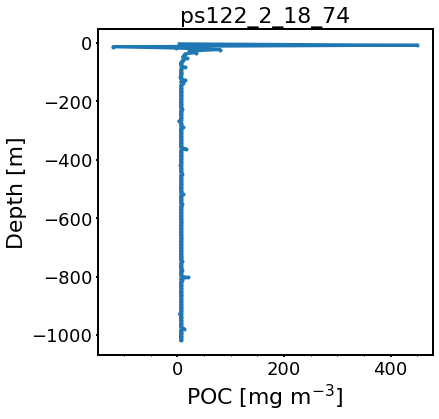

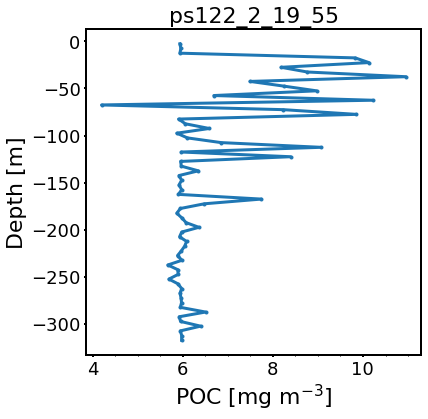

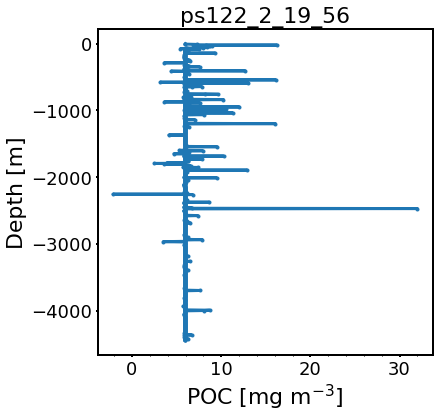

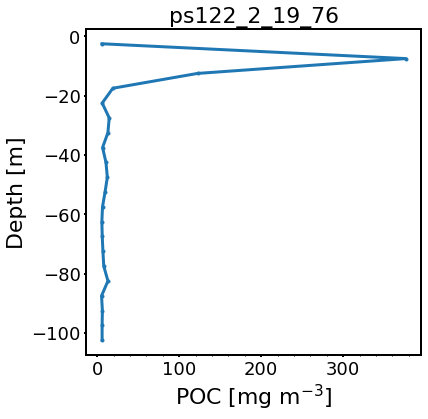

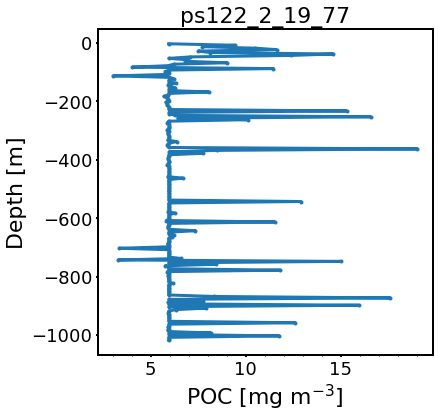

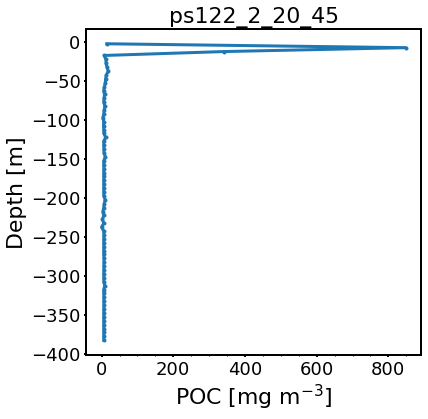

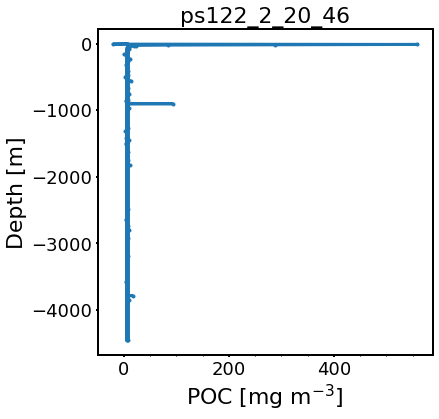

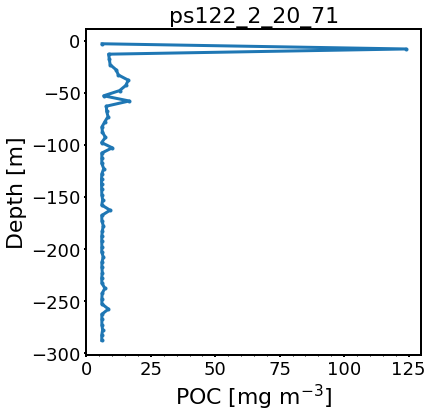

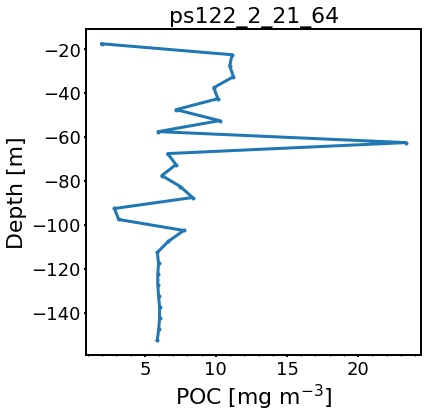

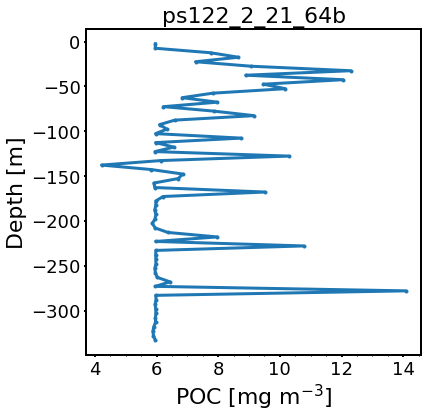

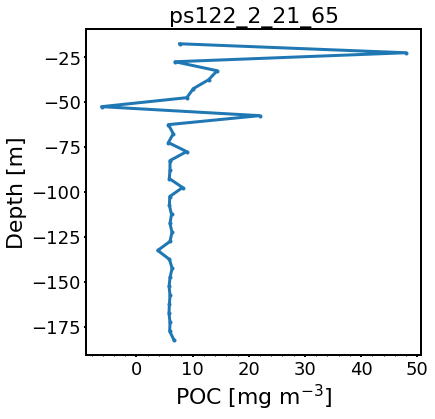

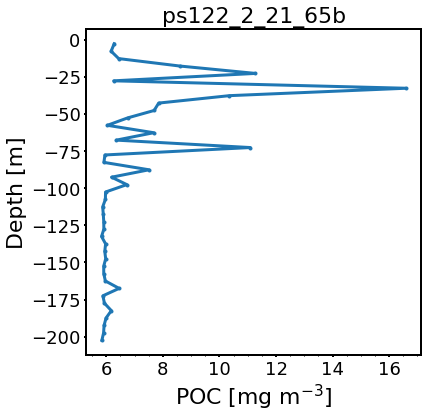

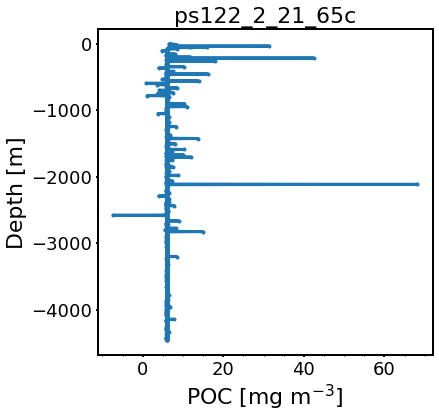

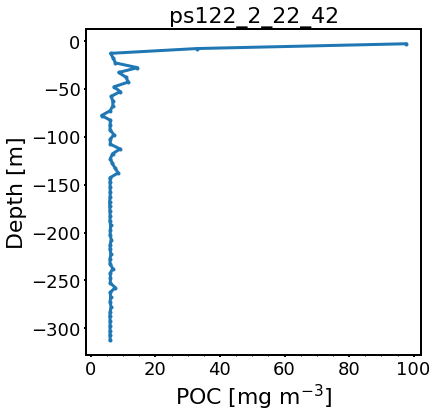

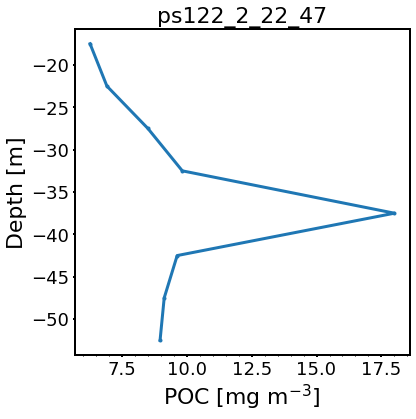

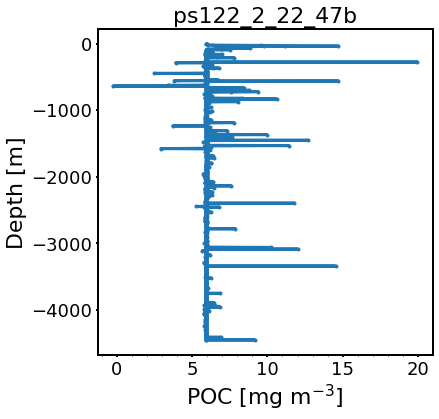

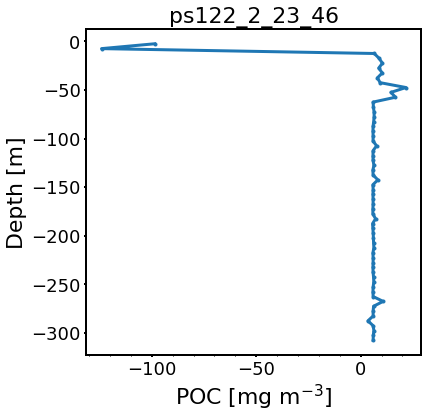

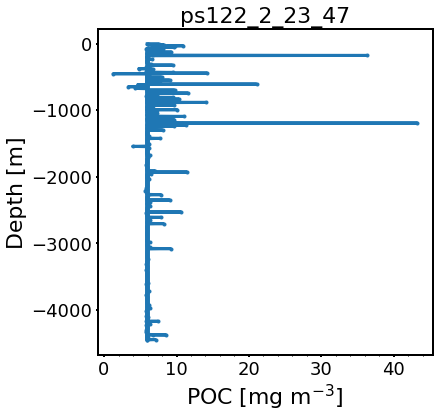

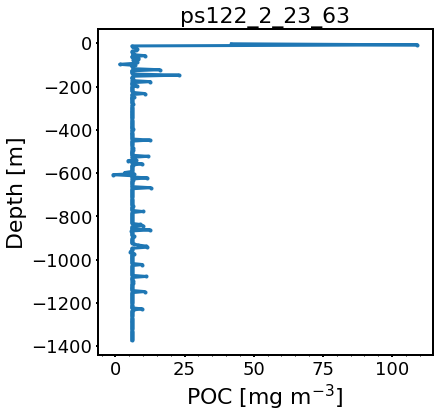

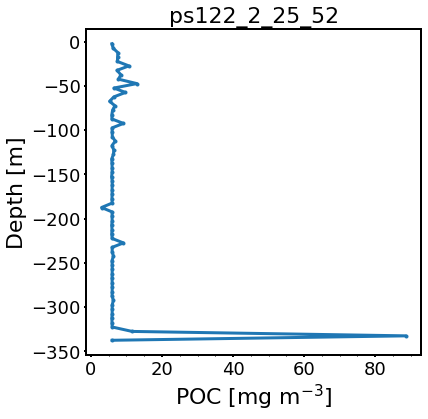

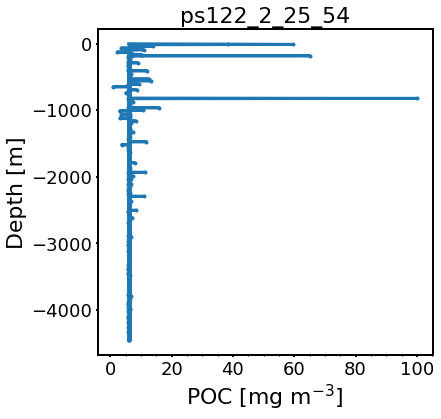

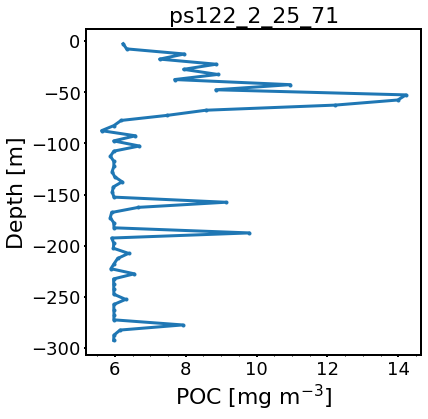

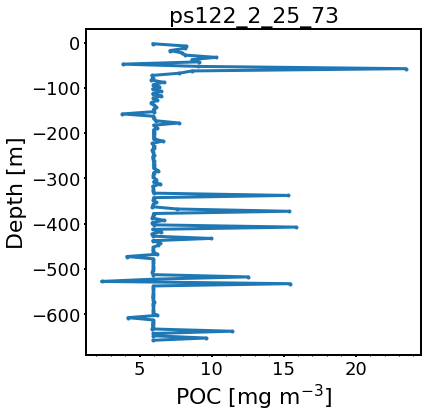

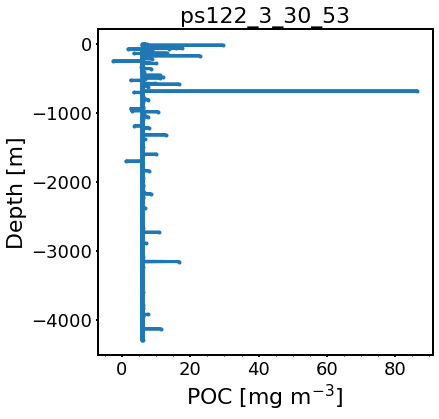

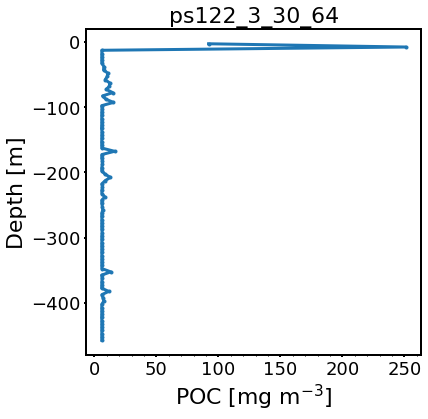

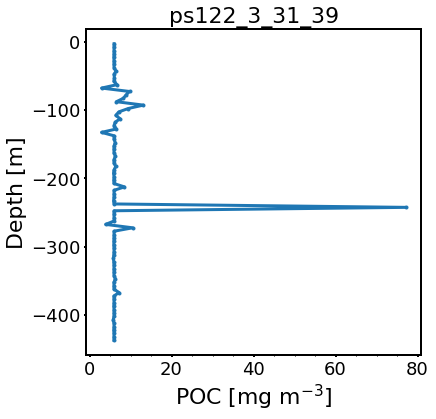

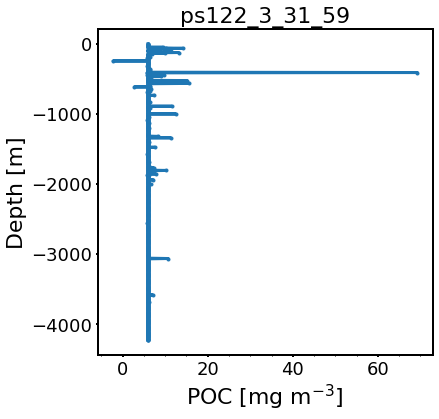

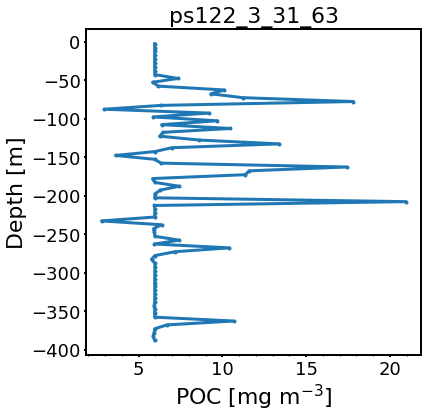

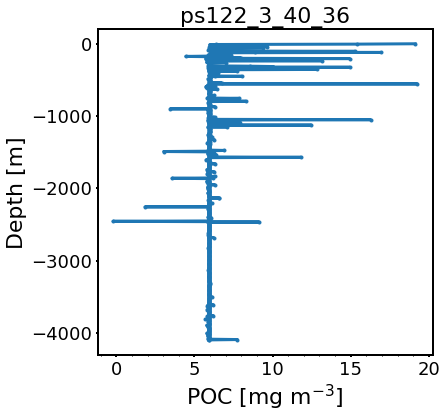

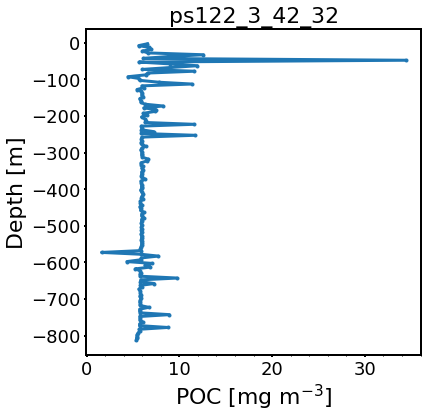

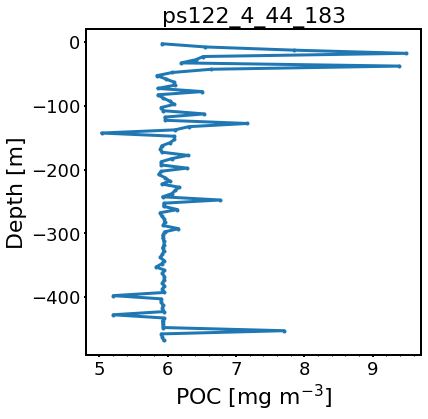

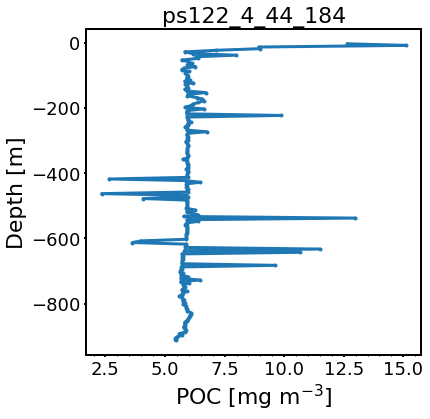

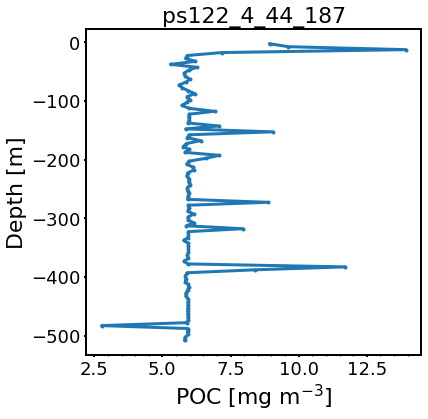

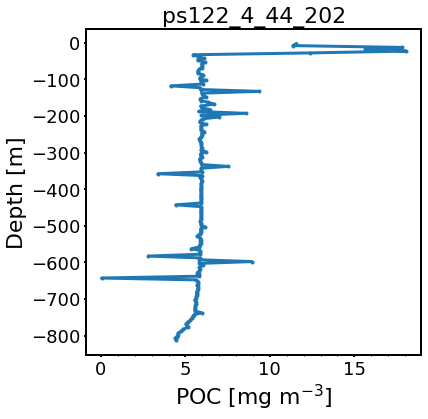

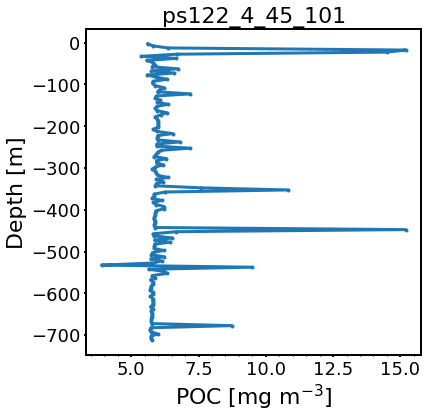

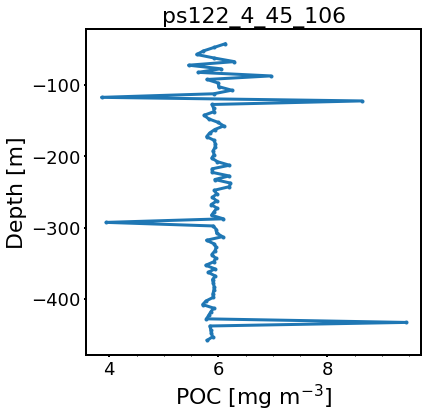

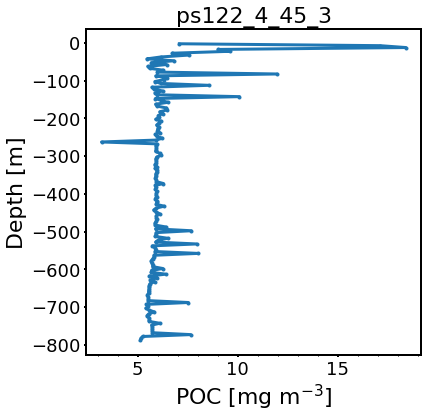

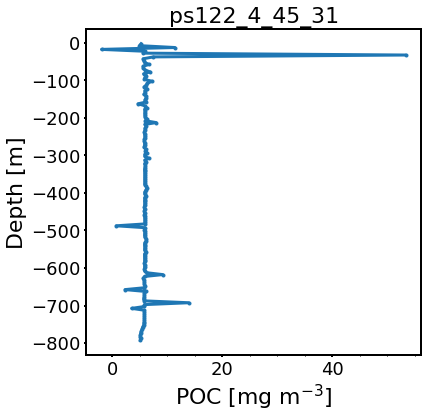

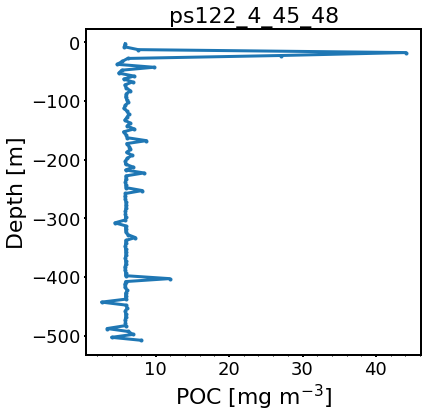

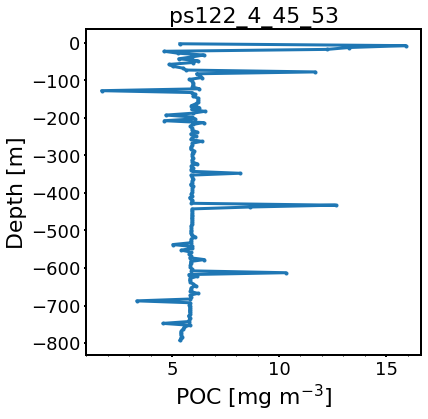

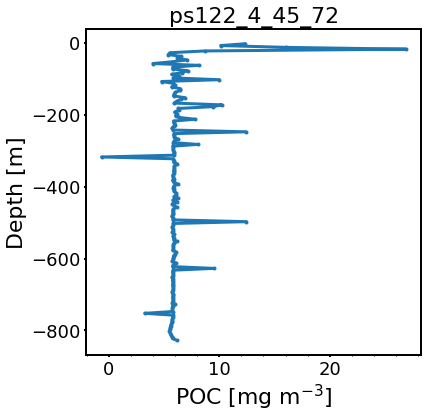

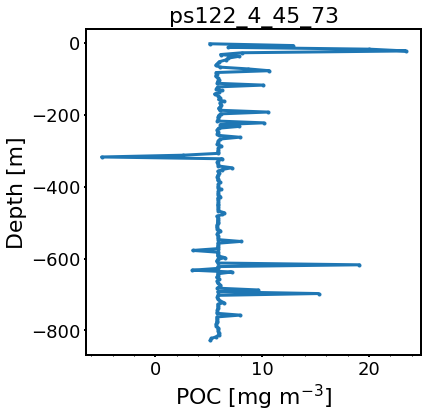

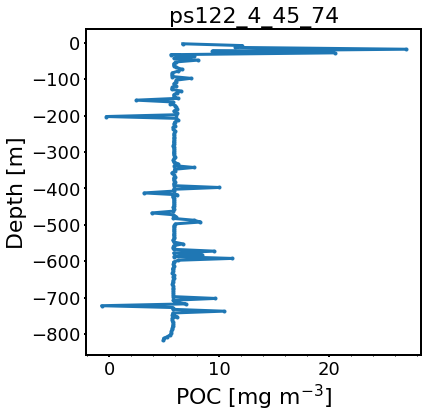

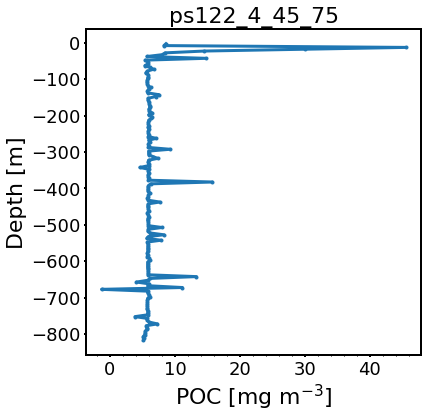

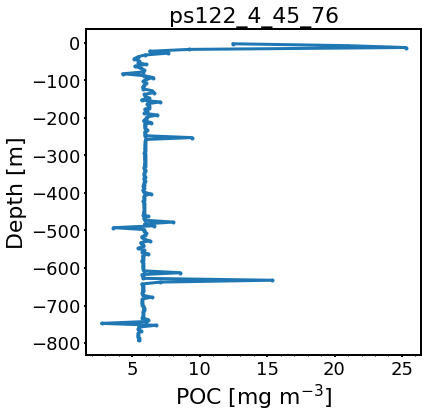

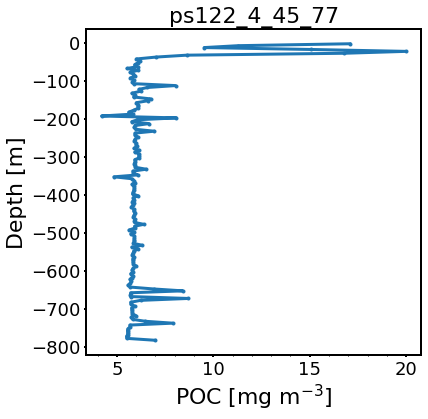

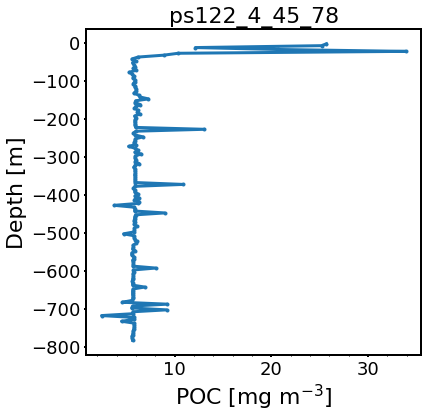

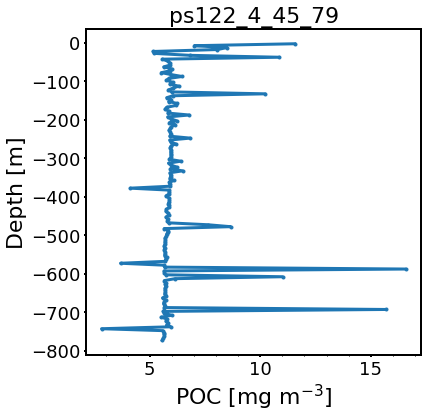

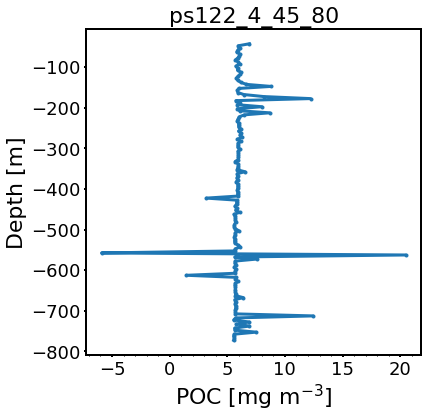

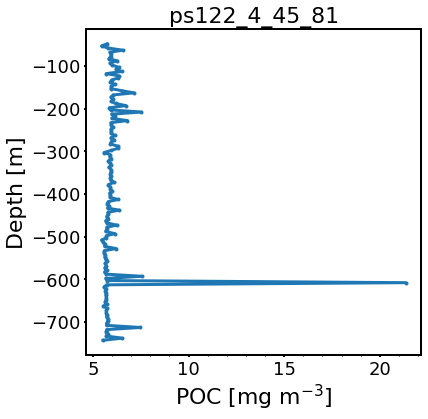

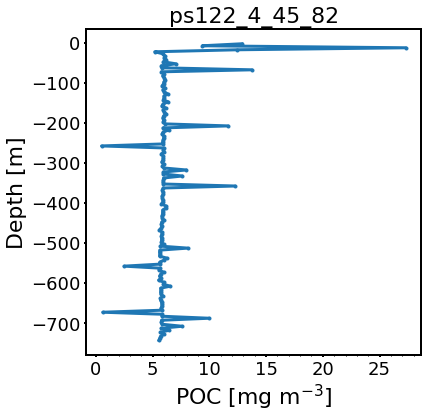

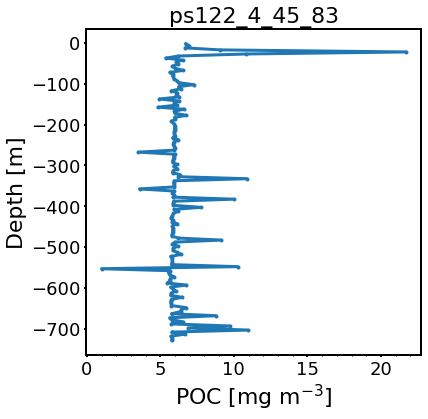

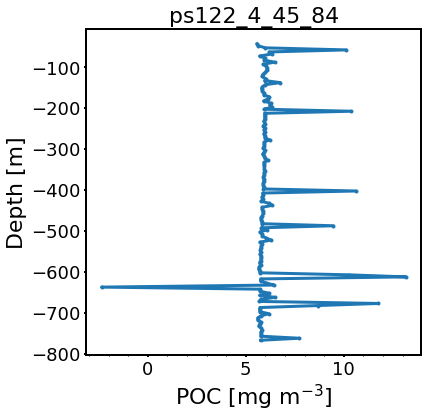

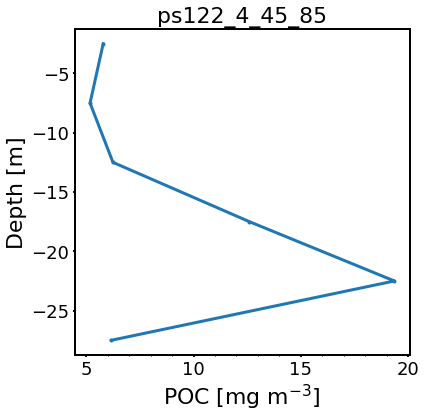

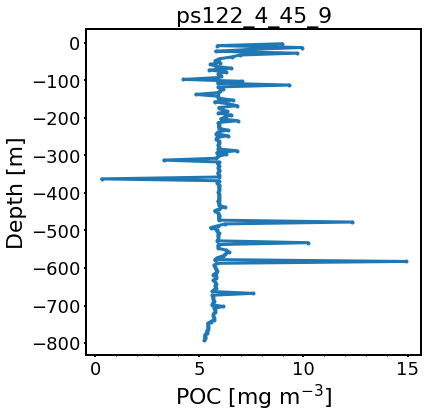

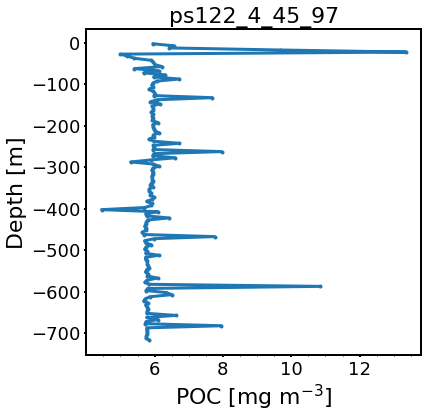

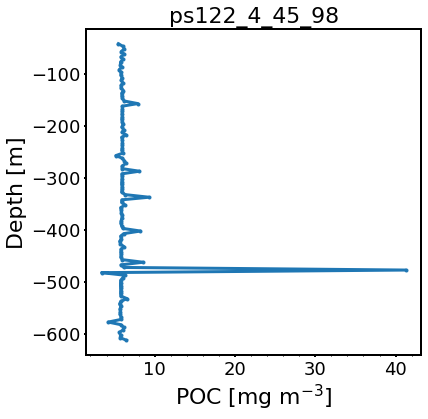

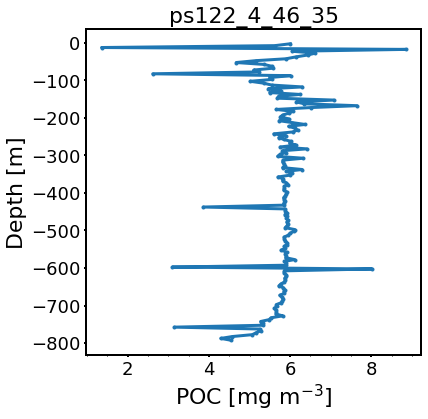

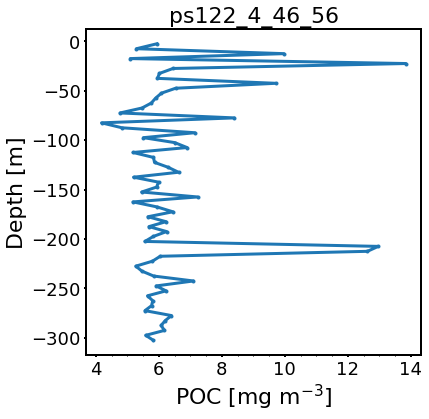

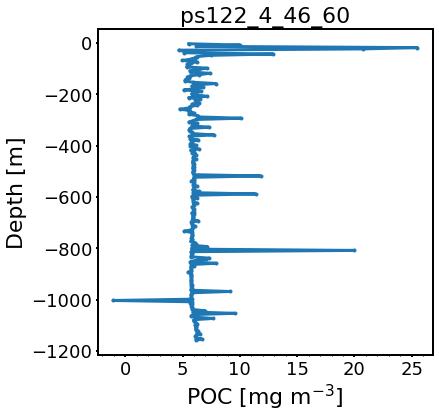

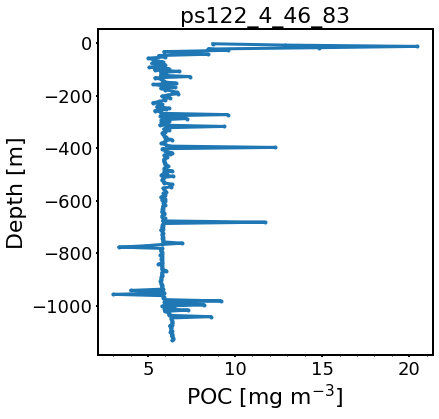

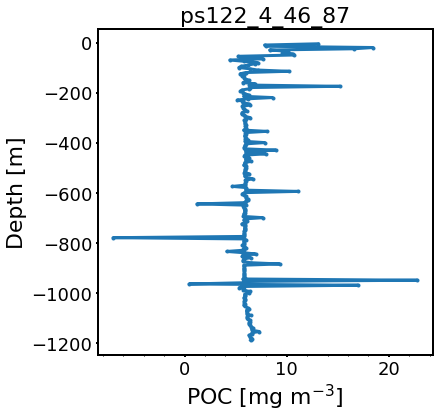

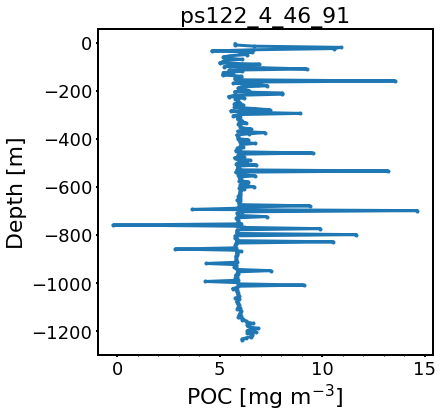

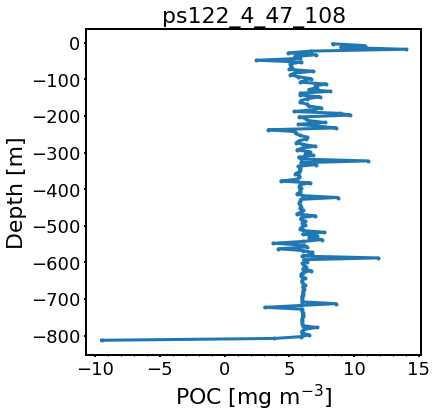

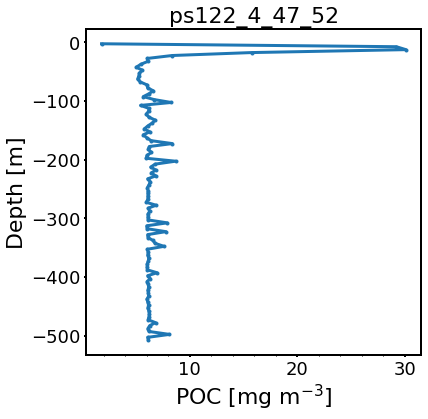

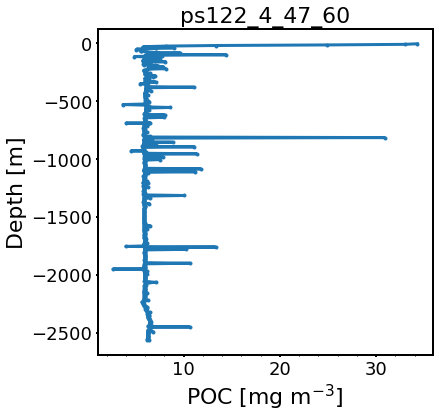

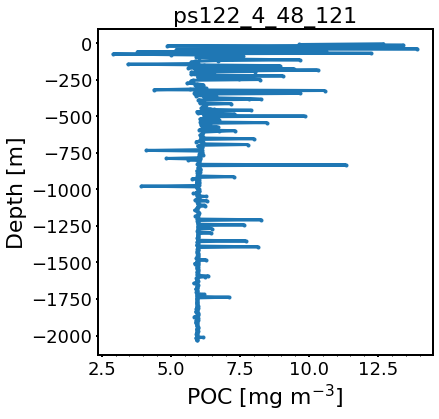

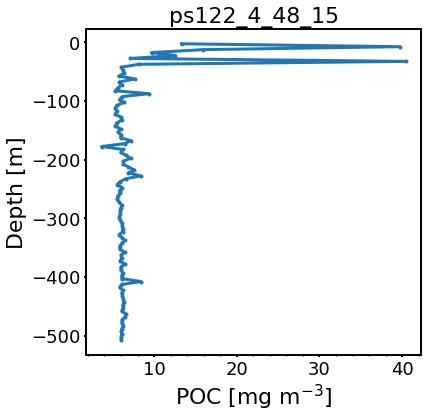

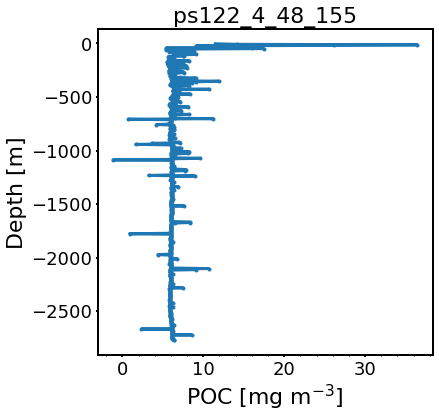

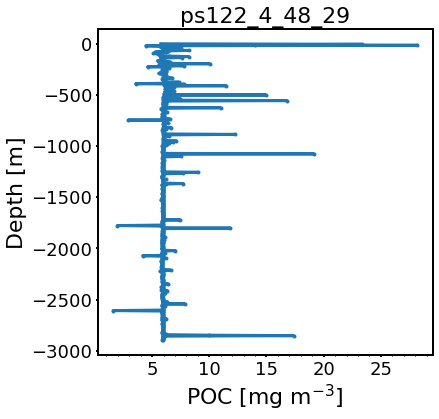

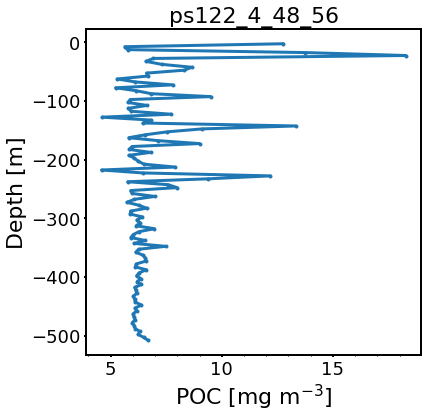

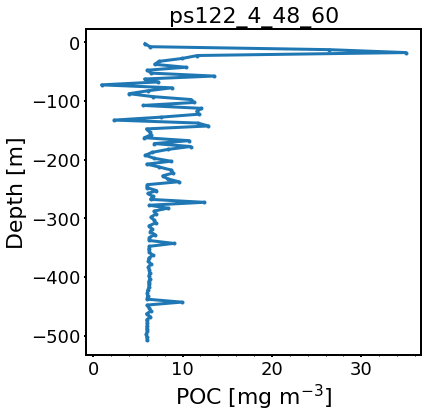

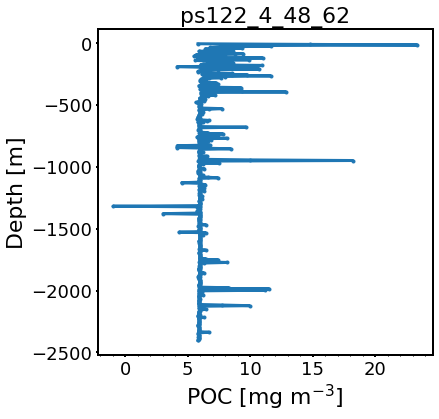

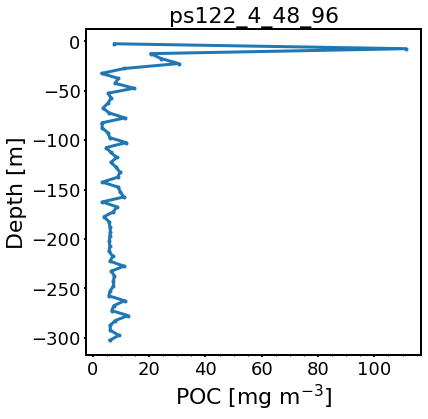

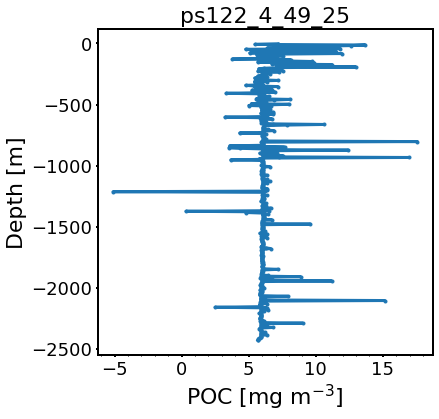

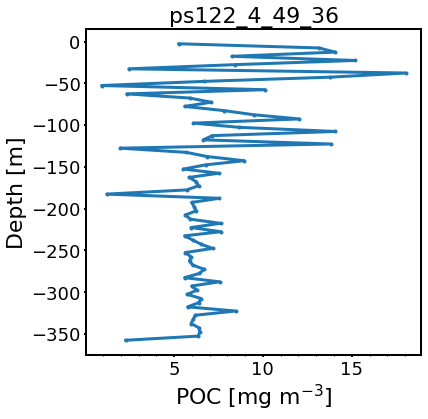

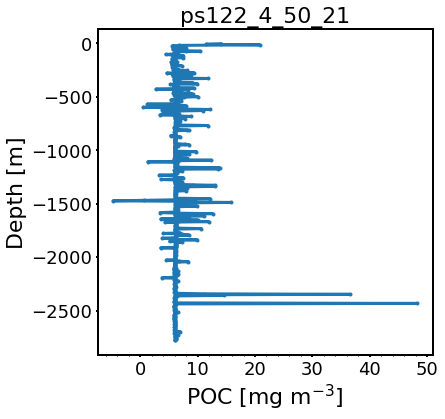

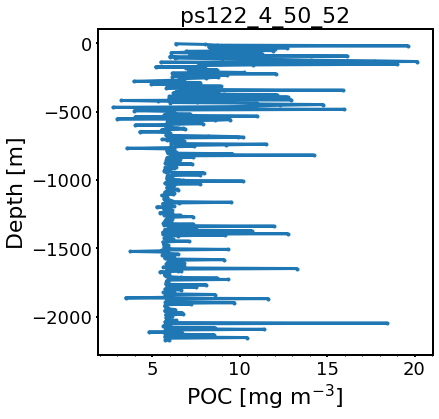

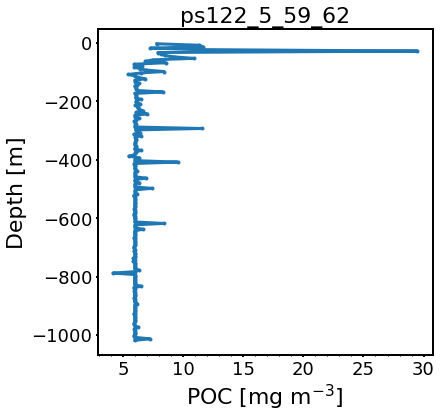

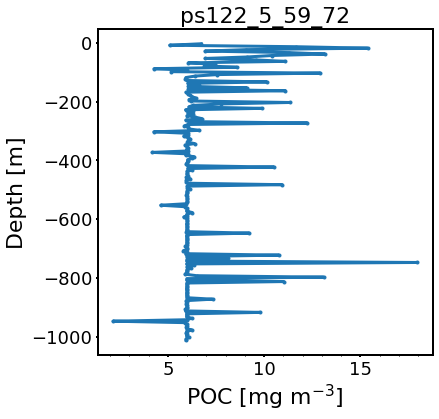

In [15]:
station_list = np.unique(df_uvp['ctd_station'])

for station in station_list:
    #print(station)
    idx = df_uvp.index[df_uvp['ctd_station'] == station].to_list()
    fig, ax = plt.subplots(figsize = (6,6))
    ax.plot(df_uvp['C_>100_µm_predicted_[µg_L-1]'][idx],-df_uvp['depth_[m]'][idx],'.-',lw=3)
    ax.set_title(station)
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('POC [mg m$^{-3}$]')